In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares,minimize
from scipy.integrate import simpson

In [2]:
# Constants
NA = 6.02214076E23  # Avogadro's number

In [3]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


## Plotting initial concentration profiles

In [4]:
# all Z's are the same! Just call it z.

In [5]:
z, c_original = compute_c_profile("density_hw_original_288.xvg")
z_1, c_1 = compute_c_profile("density_hw_r1_288.xvg")  # replicate 1
z_2, c_2 = compute_c_profile("density_hw_r2_288.xvg")  # replicate 2
z_3, c_3 = compute_c_profile("density_hw_r3_288.xvg")  # replicate 3


In [6]:
# Example concentration profiles
concentration_profiles = np.array([c_original,c_1,c_2,c_3])

Note: I think it is somewhat more rigorous to normalize the densities, since we know what the total number must be. This eliminated one source of error 

In [7]:
# Estimate the total number of ions, N_s (using Equation 13)
L_x, L_y, L_z = 4.8, 4.8, 14.4
Ntrue = 188
for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # this should be around 188
    c /= (N_s/Ntrue)
# verify normalization worked.
for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # this should be around 188
    

188.00496817343995
188.18428364160002
187.98510751343997
188.10112932479998
188.00000000000006
187.99999999999997
188.00000000000006
188.00000000000006


/tmp/ipykernel_38369/2150603121.py:5: DeprecationWarning: You are passing x=[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075 1.125 1.175
 1.225 1.275 1.325 1.375 1.425 1.475 1.525 1.575 1.625 1.675 1.725 1.775
 1.825 1.875 1.925 1.975 2.025 2.075 2.125 2.175 2.225 2.275 2.325 2.375
 2.425 2.475 2.525 2.575 2.625 2.675 2.725 2.775 2.825 2.875 2.925 2.975
 3.025 3.075 3.125 3.175 3.225 3.275 3.325 3.375 3.425 3.475 3.525 3.575
 3.625 3.675 3.725 3.775 3.825 3.875 3.925 3.975 4.025 4.075 4.125 4.175
 4.225 4.275 4.325 4.375 4.425 4.475 4.525 4.575 4.625 4.675 4.725 4.775
 4.825 4.875 4.925 4.975 5.025 5.075 5.125 5.175 5.225 5.275 5.325 5.375
 5.425 5.475 5.525 5.575 5.625 5.675 5.725 5.775 5.825 5.875 5.925 5.975
 6.025 6.075 6.125 6.175 6.225 6.275 6.325 6.375 6.425 6.475 6.525 6.575
 6.625 6.675 6.725 6.775 6.825 6.875 6.925 6.975 7.025 7.075 7.125 7.175] as a positional argument. Please change your in

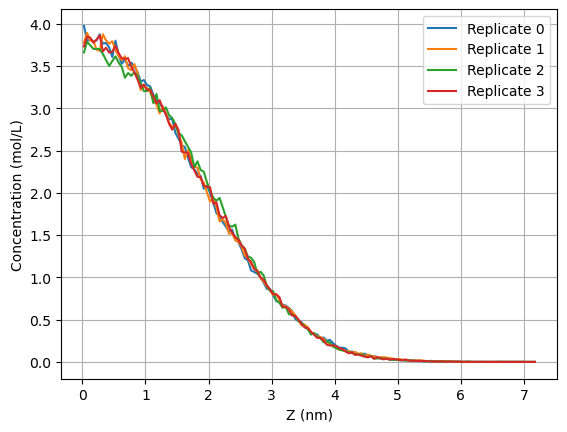

In [8]:
# Plot the concentration profiles
plt.figure()
for i, c in enumerate(concentration_profiles):
    plt.plot(z, c, label="Replicate "+str(i))
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()
plt.show()

## Bootstrapping concentration profiles

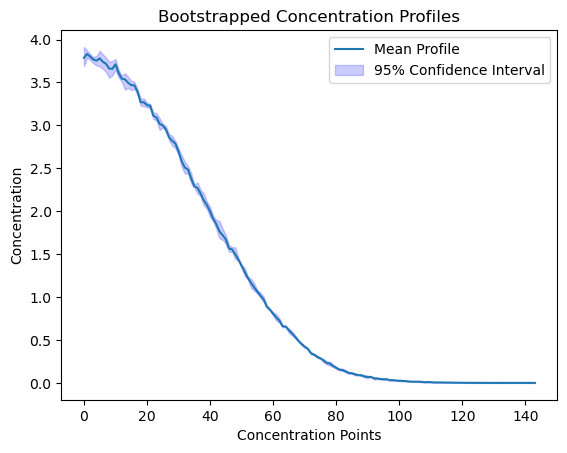

In [9]:
# Example concentration profiles
concentration_profiles = [c_original,c_1,c_2,c_3]

# Number of bootstrap samples
n_bootstrap = 1000

# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples):
    bootstrap_means = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        bootstrap_means.append(mean_profile)
    return np.array(bootstrap_means)

# Perform bootstrapping
bootstrap_means = bootstrap_profiles(concentration_profiles, n_bootstrap)

# Calculate the mean and 95% confidence intervals for each point
#mean_profile = np.mean(bootstrap_means, axis=0)

#Better to use the direct average rather than over bootstrap means
mean_profile = np.mean(concentration_profiles,axis=0)
lower_bound = np.percentile(bootstrap_means, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_means, 97.5, axis=0)

c_0 = mean_profile
# Plotting the results
conc_points = range(len(c_0))
plt.plot(conc_points, c_0, label='Mean Profile')
plt.fill_between(conc_points, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Concentration Points')
plt.ylabel('Concentration')
plt.legend()
plt.title('Bootstrapped Concentration Profiles')
plt.show()

/tmp/ipykernel_38369/2730136378.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(z, np.log(c_0), label='Mean Profile')


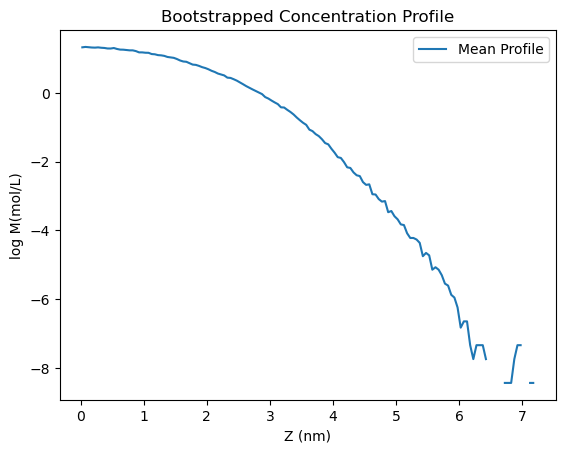

In [10]:
# Plotting the results
plt.plot(z, np.log(c_0), label='Mean Profile')
plt.xlabel('Z (nm)')
plt.ylabel('log M(mol/L)')
plt.legend()
plt.title('Bootstrapped Concentration Profile')
plt.show()

In [11]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1]* (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [12]:
# I don't think you need this function? There are no parameters in the ideal solution.
def y_ideal(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    B, alpha_1, alpha_2 = theta[0], theta[1], theta[2]  # all nm-based
    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    # term_2 = A * np.sqrt(C_max) / (1 + B * np.sqrt(C_max))
    # term_3 = -A * np.sqrt(x) / (1 + B * np.sqrt(x))
    # term_4 = (alpha_1 * (x - C_max)) + (alpha_2 * (x ** 2 - C_max ** 2))

    return term_1

def residuals_ideal(theta, x, y):
    return np.power(y_ideal(theta, x) - y, 2)

In [13]:
# Removing 0 values from the concentration profile, and the corresponding z values
z_fit = z[c_0 != 0]
c_fit = c_0[c_0 != 0]

In [14]:
# Calculating -U(z) / RT (y_values below)
k = 1.0457  # units: kJ/mol/nm^2
R = 8.31446261815324  # units: J/(mol*K)
T = 300  # units: K
A = 1.7964  # in M^(-1/2), value according to the SI
# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)

#Getting fit for full left side of eq 12
result = least_squares(residuals, [4, 0.2, 0], args=(c_fit, y_values))

#Getting fit for ideal part of eq 12 ln(c(z)/cmax)
#result_ideal = least_squares(residuals_ideal, [2, 0.1, 0.3], args=(c_0, y_values))

In [15]:
result_unweighted = result

In [16]:
#Function to get fitted theta values
def get_results(result_fit):
    result=result_fit
    # B, alpha_1, and alpha_2 have units of [nm^(-3)]^(-1/2), [nm^(-3)]^(-1), and [nm^(-3)]^(-2)
    B, alpha_1, alpha_2 = result.x[0], result.x[1], result.x[2]
    # Converting nm^(-3) to mol/L for the three parameters
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    B *= (conversion_factor ** (-0.5))  # units M^(-1/2)
    alpha_1 *= (conversion_factor ** (-1))  # units M^(-1)
    alpha_2 *= (conversion_factor ** (-2))  # units M^(-2)
    print("B=",B,'alpha1=',alpha_1,'alpha2=', alpha_2)
    newtheta=(B, alpha_1, alpha_2)
    #print(result.x)
    #print(result.cost)
    #print(result.optimality)
    return newtheta

In [17]:
#newtheta=get_results(result_unweighted)

In [18]:
# # Alirezza SI nm-based answers
# print(1.9247 / (conversion_factor ** (-0.5)))
# print(9.3393E-2 / (conversion_factor ** (-1)))
# print(3.4572E-2 / (conversion_factor **(-2)))

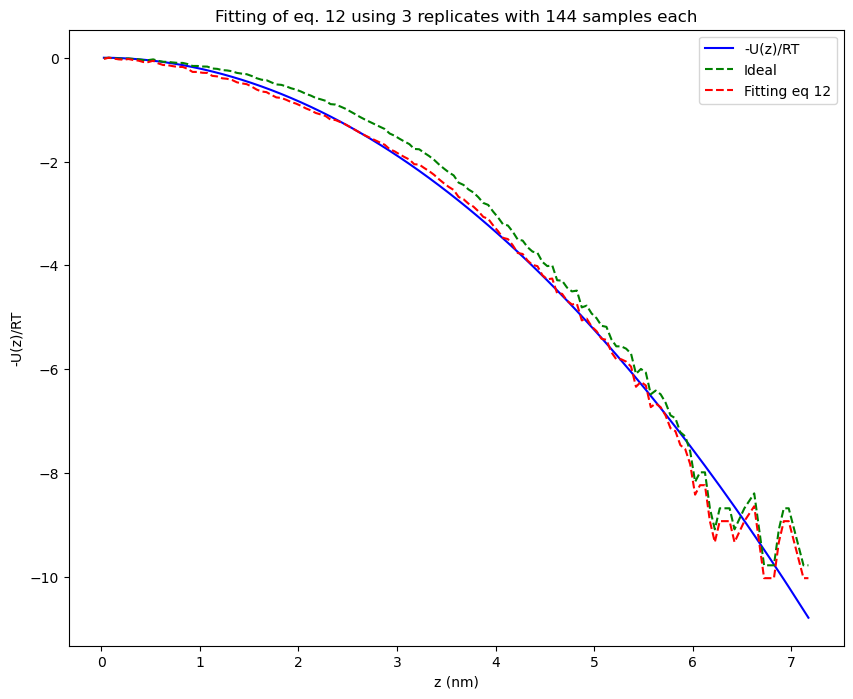

In [19]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

We do see reasonably good fit - the idea curve (green line) is corrected to the be closer to the blue (red line is closer tothe blue line). However, we would also like to not fit the noise at the end. 

To do this, we do some error propagation to find the ideal weights for the least square fit. $C(z)/C_{max}$ is a probability, or at least proportional to a probability.  The uncertainty in a probability estimate $\hat{p}$ from a histogram (whose value with infinitely collected points would be $p$), can be shown to be $\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the measured probability in that histogram bin, and $n$ is the total number of points collected over all bins.  But we are interested in the error of $\ln \hat{p}$. Generally the error in function $f$ of random variable $x$ $\delta f(x)$ is equal to $\abs{f'(x)}\delta x$. So $\delta (\ln p) = \frac{\delta p}{p} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n\hat{p}^2}}$.

For weighted least squares, it can be show that the weights should be proportional to 1/variance of the data point. The variance will be $(\delta\ln p)^2 = \frac{\hat{p}(1-\hat{p})}{n\hat{p}^2} = \frac{1-\hat{p}}{np}$.  The weights are only defined up to a constant, so we can just use $\frac{1-p}{p}$.  To do this, we have to normalize $C/C_{max}$, which is easy to do, we call it K. So the weights should be proportional to $\frac{C/K}{1-C/K} = \frac{C}{K-C}$.  So the most well defined points will get the most probability, the noisiest points the least.

In [20]:
norm = 188/(4.8*4.8)
print(norm)

8.159722222222223


In [21]:
def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(calc_y(theta, x) - y, 2)

In [22]:
#Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, [4, 0.2,-0.01], args=(c_fit, y_values))

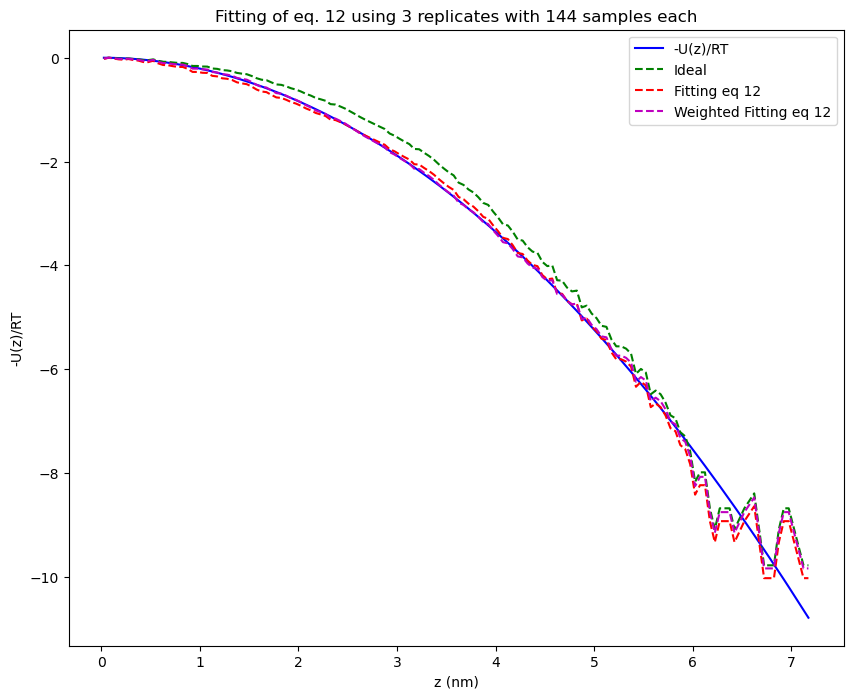

In [23]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences

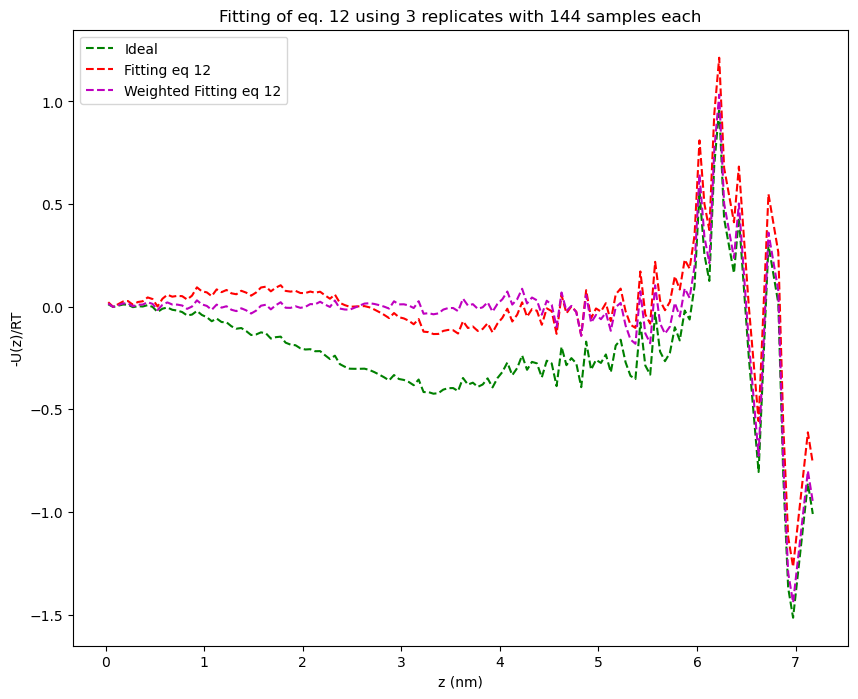

In [24]:
# plot the results
plt.figure(figsize = (10,8))
#plt.plot(z, calc_y(idealtheta,c_0), 'g--', label="Ideal")
plt.plot(z_fit, y_values-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
# we want the direct output of results plotted here, not the rescaled ones.
plt.plot(z_fit, y_values-calc_y(result.x,c_fit), 'r--', label="Fitting eq 12")
plt.plot(z_fit, y_values-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

The weighted fitting is much closer to zero over the range with reasonable concentrations, say z=5.

In [25]:
zlim = 4

In [26]:
np.std(y_values[z_fit<zlim]-calc_y(result.x,c_fit[z_fit<zlim]))

0.07174155763396328

In [27]:
np.std(y_values[z_fit<zlim]-calc_y(result_weighted.x,c_fit[z_fit<zlim]))

0.016195388582744018

Compare the distribution of the parameters with the fit!

In [28]:
print("B =", result_weighted.x[0])
print("alpha1 =", result_weighted.x[1])
print("alpha2 =", result_weighted.x[2])

B = 1.4401255650435434
alpha1 = 0.2888230424190373
alpha2 = -0.02400355411439836


In [29]:
print("B =", result_unweighted.x[0])
print("alpha1 =", result_unweighted.x[1])
print("alpha2 =", result_unweighted.x[2])

B = 8171.673226824948
alpha1 = -0.09898792032437297
alpha2 = 0.042696173575514244


And we expect that the parameters will be more consistent between runs with weighting.

In [30]:
trialp = [4, 0.1,0.0]
# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples, res_func):
    bootstrap_params = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)
        result = least_squares(res_func, trialp, args=(c_fit, y_values))
        bootstrap_params.append(result.x)
        
    return np.array(bootstrap_params) # list

Parma 0 = 1852.1600748118003 +/- 5407.396220662476


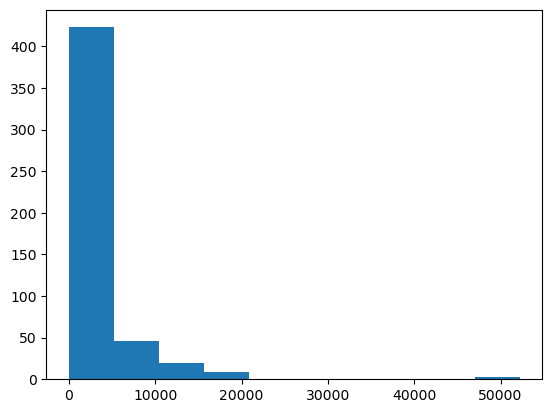

Parma 1 = 0.3827849890299612 +/- 0.38210296989466397


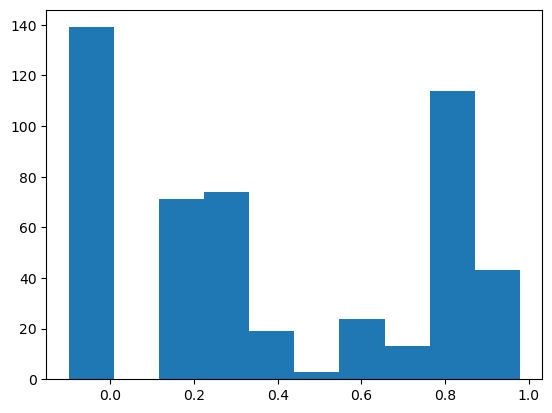

Parma 2 = -0.022179534246097775 +/- 0.04464319444330536


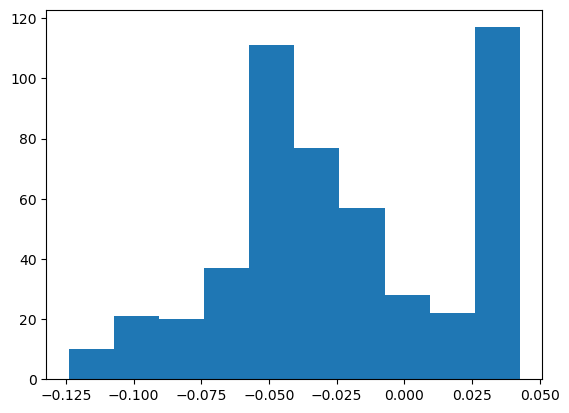

In [31]:
# Perform bootstrapping with unweighted fit
n_bootstrap = 500
bootstrap_params = bootstrap_profiles(concentration_profiles, n_bootstrap, residuals)

for i in range(len(trialp)):
    pd = bootstrap_params[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Parma 0 = 1.4141602717336232 +/- 0.6598860185620233


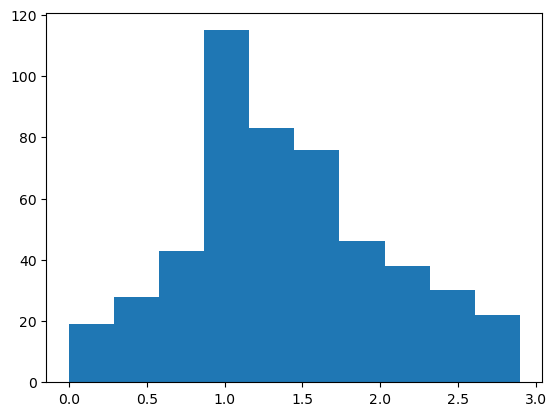

Parma 1 = 0.34807714244087 +/- 0.13235056971388012


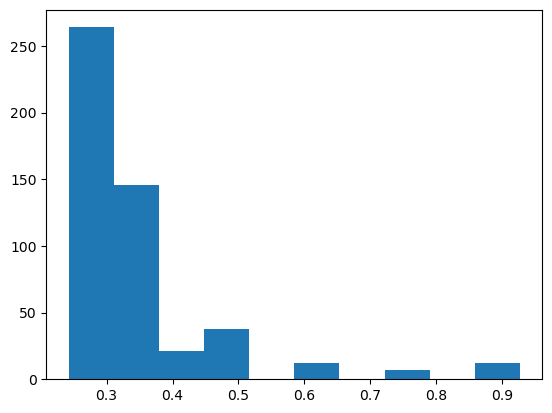

Parma 2 = -0.030901320875129885 +/- 0.010191764381186151


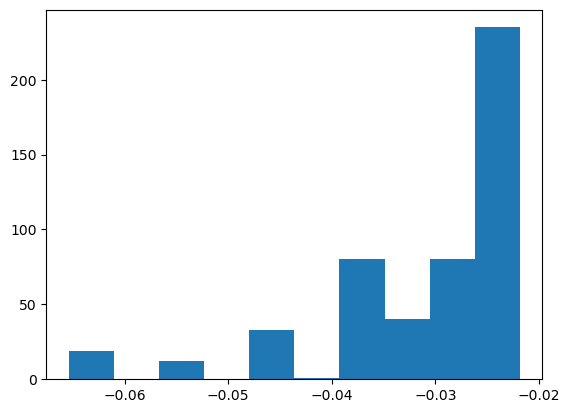

In [32]:
# Perform bootstrapping with weighted residuals
n_bootstrap = 500
bootstrap_params  = bootstrap_profiles(concentration_profiles, n_bootstrap, weighted_residuals)

for i in range(len(trialp)):
    pd = bootstrap_params[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Much more consistent performance!

Now, we try maximum likelihood parameter optimization.  The basic idea is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have.

$P(a|x) \propto P(x|a)$

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

To observe how this works, we first do a trial problem. We generate data from a spring with a spring constant of `setconst`, and take the positive half.  We normalize such that the total number of particles is 100. This is our collected distribution.  We wish to recover the correct parameters for this distribution.  We treat it as a single parameter model with the force constant.  

Some initial math: if the force constant is $k$, then the unnormalized density is $e^{-kz^2/2RT} = e^{-x^2/2\sigma^2}$, so $\sigma^2 = RT/k$, and $\sigma = \sqrt{RT/k}$. The normalization constant for the Gaussian is $\sqrt{2\pi\sigma^2} = \sqrt{2\pi R T/k}$, which is $\sqrt{\pi R T/2k}$ for the half Gaussian.

In [33]:
from scipy.integrate import quad

In [34]:
setconst=60
Np = 100

In [35]:
zp = np.sqrt(R*T/setconst)*np.random.randn(100000)
zph = zp[zp>0]

In [36]:
zp_ideal = lambda z: np.exp(-setconst*z*z/(2*R*T))
zp_norm = quad(zp_ideal,0,100)[0]
print(zp_norm)
zp_norm = np.sqrt(np.pi*R*T/(2*setconst))
print(zp_norm)

8.080942810052731
8.080942810052731


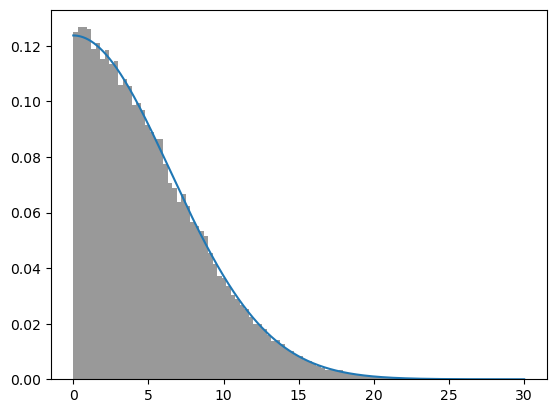

In [37]:
zgrid = np.linspace(0,30,1000)
plt.plot(zgrid,zp_ideal(zgrid)/zp_norm)
plt.hist(zph,density=True,bins=100,color='k',alpha=0.4)
plt.show()

If $p_{ideal} = e^{-U/RT}$, then the concentration is $(N_p/p_{norm})\times p_{ideal}(z)$, and the probability of a particle occuring at a given distance is $p_{ideal}(z)/p_{norm}$.

We now assume that we don't know what distribution the data is taken from, but whsh to figure out the best fit of this distribution to a paramterized distribution.  We assume our parameterized concentration is of the form $f(a,z) = N e^{-az^2/2RT}$, multiplied by any needed normalizing constant $N$ to satisfy the total amount. The logarithm of this probability is $\ln p(a,z) = -\frac{az^2}{2RT} - \ln N$. We can figure out the normalizing constant of our parameterized distribution, but we do not know the true distribution, so we may have to estimate the normalizing constant. 


Next, we need to write out a formula for $\prod_i p(a,z_i)$.  Note that this needs to be the **normalized** probability, otherwise we won't be writing products of percentages.

We then attempt to maximize $\prod_i p(a,z_i)$, where the product is over the data samples we have collected.  The values of $a$ that maximize this product will be the maximum likelihood distribution. 

Generally it is more numerically stable, and often easier to work with, to maximize the log likelihood, $\ln \prod_i p(a,z_i) = \sum_i \ln p(a,z_i)$. 

For our trial function, the log likelihood is: 
$-az^2/(2RT)-\ln \sqrt{\pi R T/2a} = -az^2/(2RT) - 1/2 \ln (\pi R T/2) + 1/2\ln a$. If we want to minimize this, we can eliminate any terms that do not involve the parameter $a$, so we can minimize simply $-az^2/RT+ 1/2 \ln a$. 

In [38]:
def logp(a,z):
    return -a[0]*z*z/(2*R*T) + 0.5*np.log(a[0])

Set up the sum of the log probabilities of the data compared to the model.  Multiply it by -1 since we only have minimizers, not maximizers.

In [39]:
def nl(a,z):
    # sum of the log likelihood
    csum = np.sum(logp(a,z))
    return -1*csum

Now minimze!

In [40]:
results = minimize(nl,[4],args=(zph),method='L-BFGS-B')

The result is consistent with the model up to noise!

In [41]:
results.x

array([60.37517491])

In [42]:
results = minimize(nl,[100],args=(zph),method='L-BFGS-B')
print(results.x)

[60.37492671]


We get the right answer to within statistical precision.

### The actual problem

We now apply the problem to the one of the chemical potential of ions trapped in a harmonic potential.

First, import the data.

In [43]:
import pickle
import pdb

In [44]:
with open('ion_array.bin', 'rb') as f:
    zs = pickle.load(f)

In [45]:
ionz = np.abs(np.array(zs)-72)/10 # rescale the data.

In [46]:
zvals = ionz.flatten()

For this problem, we are essentially finding the parameters that examine the probability of finding an ion at a given $x$, since concentration is proportional to probability.  

We convert the concentration $C(z)/C_{max}$ to an unnormalized probability $p(z)$.  

$\ln p(z|B,\alpha_1,\alpha_2) \propto \ln \frac{C(z)}{C_{max}}$

$\ln \frac{C(z)}{C_{max}} = \sum_i -\frac{kz^2}{2RT} + A\left(\frac{C(z)^{1/2}}{1+BC(z)^{1/2}} - \frac{AC_{max}^{1/2}}{1+BC_{max}^{1/2}} \right) -\alpha_1(C(z)-C_{max}) - \alpha_2(C(z)^2-C_{max}^2)$  



$C_{max}$ and also the normalizing constant will be fixed by the fact that we have a fixed number of ions present.

This is actually not ideal for maximizing, since the concentration $c(z)$ occurs on both sides. It would be great if we could algebraically solve for $c(z)$, but this does not appear to be possible.

We can't actually leave out any of the terms, because all of the terms involve the parameters implicitly (including $C_{max}$).

We approach the problem the following way:

 - Given a set $[B,\alpha_1,\alpha_2]$, find the concentration $C(z|B,\alpha_1,\alpha_2)$ that satisfies those parameters. 
 - This will need to be done self-consistently, as each time the parameters change, $C_{max}$ will also change.
 - We will make use of a reference ideal distribution with no parameters.


Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [47]:
from scipy.integrate import quad, simpson, trapezoid

In [48]:
red_U_app = lambda z: 1000*k*z*z/(2*R*T)
cz_ideal = lambda z: np.exp(-red_U_app(z))

In [49]:
ideal_norm = quad(cz_ideal,0,10)[0]
print(ideal_norm)
ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k))
print(ideal_norm)

1.9356824136314768
1.9356824138152555


In [50]:
cmax_ideal=N_s/(4.8*4.8*ideal_norm)
print(cmax_ideal)

4.215424061294903


One issue is doing the integration of the model parameter to normalize it. 

We could try to take advantage of importance sampling - if we have two unnormalized probability distributions $q_i$ and $q_j$ ($p_i$ normalized), and we have samples from $q_i$, then we can have

$1 = \int p_j(z) dz \\
= \int \frac{p_j(z)}{p_i(z)}p_i(z) \\
= \int \frac{q_j(z)/Z_j}{q_i(z)/Z_i} p_i(z) \\
= \int \frac{Z_i}{Z_j} \frac{q_j(z)}{q_i(z)} p_i(z) \\
\approx \frac{Z_i}{Z_j} \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)} \\
\frac{Z_i}{Z_j} \approx \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)}
$

 So if we know the ideal solution normalizing factor, we can find

$Z_{trial} = Z_{ideal} \frac{1}{N} \sum_n \frac{q_{ideal}(z)}{q_{trial}(z)} =  Z_{ideal} \left \langle \frac{q_{ideal}(z)}{q_{trial}(z)} \right \rangle$

However, this doesn't actually appear work if we using this equation to optimize the parameters, because if we have a mismatch between the trial function and the data sampled; if the trial function functional form doesn't actually match the PDF measured, then we will continually get worse results.

Let's do something silly/simple and assume we have enough data, and just take the points that are output, and do Simpson's rule on those.

In [51]:
# define a function that iterates the calculation of a concentration.
def czfunc(a,z,cz):
    # exponential of eq 12 for ln c/cmax for the data points
    cznew = np.exp(logprobfunc(a,z,cz))
    # these indices do not need to be repeated if this is expensive,
    # but if we bootstrap, they will change, so keep for now. 
    zunique,locs = np.unique(z,return_index=True)
    # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],zunique)
    cznorm_ratio = ideal_norm/newarea
    return (cmax_ideal*cznorm_ratio)*cznew

In [52]:
def logprobfunc(a,z,cz,A=A):
    # we need to calculate the maximum concentration 
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [53]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

How many duplicates of each $z$ value are there?  

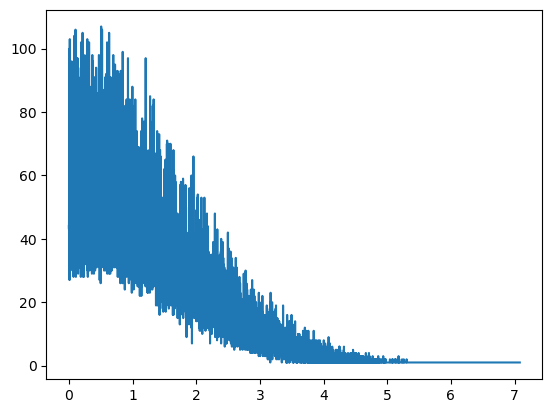

In [54]:
zsparse,zcount=np.unique(zvals,return_counts=True)
plt.plot(zsparse,zcount)
plt.show()

Turns out, quite a few!  We can take advantage of that; each time the same $z$ is processed, it would result in the same number, so we can calculate the contribution for each $z$ once and then mulitply by the number of times it appears.

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 76.48216
1 8.331021
2 1.4046497
3 0.25546739
4 0.049103808
5 0.009644568
6 0.0019933288
7 0.0006577148


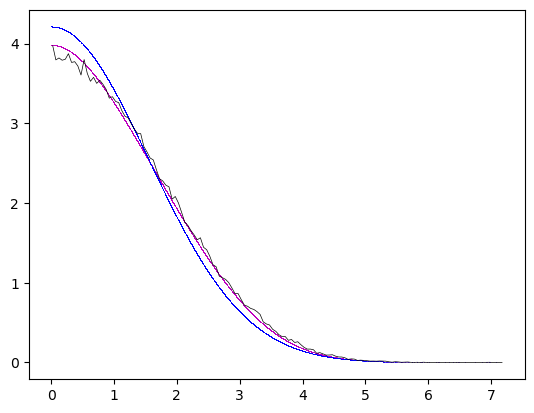

In [55]:
newp = np.array([1.35,0.33,-0.04])
c_new = converge_c(newp,zvals,cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zvals,c_new,s=0.1,lw=0.1,c='m')
plt.scatter(zvals,cmax_ideal*cz_ideal(zvals),s=0.1,lw=0.1,c='b')
plt.plot(z,concentration_profiles[0],'k',lw=0.5)
plt.show()

0 13.363842
1 1.5527601
2 0.26444435
3 0.048486248
4 0.009332019
5 0.0018396403
6 0.00037593924


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


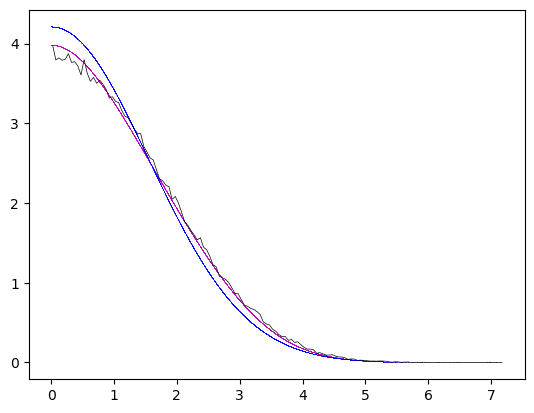

In [56]:
# we can converge faster with sparse data.
newp = np.array([1.35,0.33,-0.04])
zsparse,zcount=np.unique(zvals,return_counts=True)
c_new_sparse = converge_c(newp,zsparse,cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zsparse,c_new_sparse,s=0.1,lw=0.1,c='m')
plt.scatter(zsparse,cmax_ideal*cz_ideal(zsparse),s=0.1,lw=0.1,c='b')
plt.plot(z,concentration_profiles[0],'k',lw=0.5)
plt.show()

In [57]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [58]:
from timeit import default_timer as timer

In [59]:
# summing over all the values is slow
start = timer()
results = minimize(neglliter,newp,args=(zvals,c_new),method='Nelder-Mead',options={'maxiter':200})
# this one also works pretty well
#results = minimize(neglliter,newp,args=(zvals,c_new),method='COBYLA',options={'rhobeg':0.001})
end = timer()
print(end-start)

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


318.95475510098913


In [60]:
# plot the results
print(results)
c_opt = converge_c(results.x,zvals,cz_start=c_new,lim=0.0001,verbose=False)
optp = results.x
print(optp)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 105700.40625
             x: [ 2.465e+00  2.242e-01 -2.071e-02]
           nit: 112
          nfev: 258
 final_simplex: (array([[ 2.465e+00,  2.242e-01, -2.071e-02],
                       [ 2.465e+00,  2.242e-01, -2.071e-02],
                       [ 2.465e+00,  2.242e-01, -2.071e-02],
                       [ 2.465e+00,  2.242e-01, -2.071e-02]]), array([ 1.057e+05,  1.057e+05,  1.057e+05,  1.057e+05]))


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


[ 2.46487201  0.2241518  -0.02070808]


In [61]:
# yep, we have reduced the negative log likelihood, 
# i.e. maximized the likelihood
print(neglliter(newp,zvals,c_new,doeval=True))
print(neglliter(optp,zvals,c_opt,doeval=True))

105751.96875
105700.5625


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


See what the improved solution looks like! (red line vs magenta line)

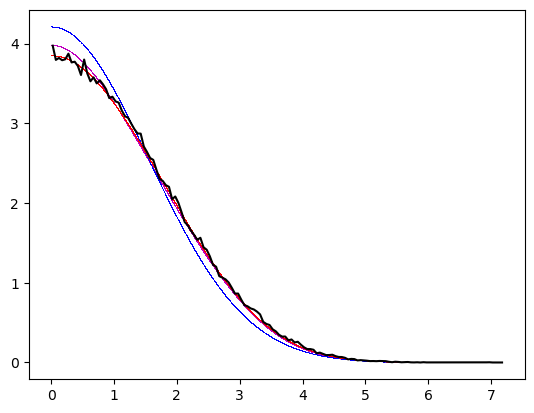

In [62]:
plt.scatter(zvals,c_new,s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.scatter(zvals,cmax_ideal*cz_ideal(zvals),s=0.1,lw=0.1,c='b')
plt.scatter(zvals,c_opt,s=0.1,lw=0.1,c='r')
plt.show()

Note we can make this much faster by noting that there are a lot of repeats of each value, so we can simplify the sum (MIGHT be slightly different because of rounding).


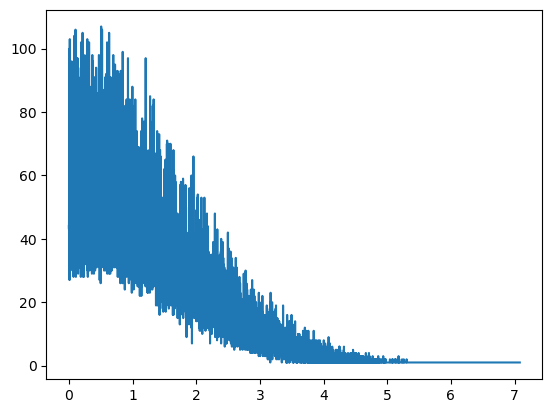

In [63]:
zsparse,zcount=np.unique(zvals,return_counts=True)
plt.plot(zsparse,zcount)
plt.show()

In [64]:
# this is now much faster, and gives essentially the same answer.
start = timer()
results = minimize(neglliter,newp,args=(zsparse,c_new_sparse,zcount),method='Nelder-Mead')
end = timer()
print("time=",end-start)
print(results)
full_opt = results.x

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


time= 1.567392284006928
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 105700.49894010276
             x: [ 2.383e+00  2.246e-01 -2.056e-02]
           nit: 97
          nfev: 219
 final_simplex: (array([[ 2.383e+00,  2.246e-01, -2.056e-02],
                       [ 2.383e+00,  2.246e-01, -2.056e-02],
                       [ 2.383e+00,  2.246e-01, -2.056e-02],
                       [ 2.383e+00,  2.246e-01, -2.056e-02]]), array([ 1.057e+05,  1.057e+05,  1.057e+05,  1.057e+05]))


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


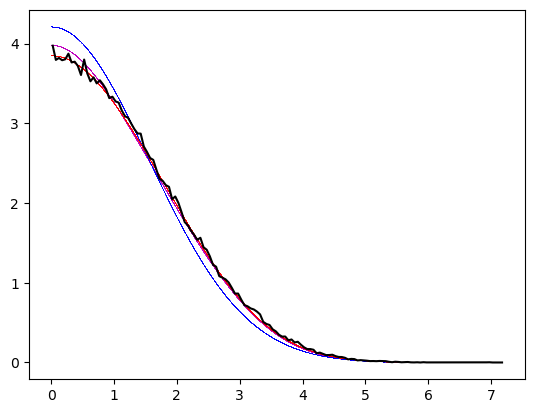

In [65]:
# now plot the new data 
c_opt_sparse = converge_c(results.x,zsparse,cz_start=c_new_sparse,verbose=False)
plt.scatter(zsparse,c_new_sparse,s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.scatter(zsparse,cmax_ideal*cz_ideal(zsparse),s=0.1,lw=0.1,c='b')
plt.scatter(zsparse,c_opt_sparse,s=0.1,lw=0.1,c='r')
plt.show()

Note that the parameters are somewhat different, but the curves are about the same; the space appears to be relatively degenerate, in that there's a large volume of parameters that all give similar results. But that's probably OK for osmotic coefficients, as there will also be many parameters that thus give about the same osmotic coefficient. 

This seems to work!  Things to do:

1. Implement bootstrapping. A key here is one can now bootstrap over all the SAMPLES (like 188,000), not the profiles (4).
2. See what happens when you use all the data from the trajectories.  You can just dump them all into one big array - the bootstrapping is on samples, not on the trajectories.
3. See if you can get away with 2 paramters, not 3, and still get a good fit.  
4. Bootstrap around the osmotic coefficient/pressure calculation given the curve - this will be much less noisy than the parameters themselves. 


In [66]:
# Function to perform bootstrapping over _samples_
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

In [67]:
bparams,bcs = bootstrap_samples(zvals,500,neglliter,results.x)

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9740000e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)
/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


0 [ 2.66044668  0.22282197 -0.02218981] 105339.95371665104


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


1 [ 2.9680005   0.20570972 -0.01971356] 105164.3081542642


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


2 [ 2.19558932  0.24008924 -0.0233082 ] 105510.96798571665


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


3 [ 3.01722601  0.20912369 -0.01988641] 105537.34840905933


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


4 [ 1.80664224  0.27073453 -0.02647394] 105891.25180120018
5 [ 2.6516086   0.21592052 -0.01995854] 105580.53711509361
6 [ 2.39808236  0.22818222 -0.02081425] 105931.19818617446
7 [ 3.04082615  0.20222189 -0.01808956] 105644.43498122497
8 [ 2.42420926  0.22585189 -0.02160789] 105334.69080443596
9 [ 1.59614098  0.28142766 -0.02775773] 105434.1796917471


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


10 [ 2.62594348  0.24153333 -0.02485036] 106082.37305714093
11 [ 3.11606306  0.17780475 -0.01266892] 105602.33492142482
12 [ 2.51958968  0.21916946 -0.02022318] 105547.08697953401
13 [ 2.52214002  0.20438992 -0.01555082] 106007.09536494633
14 [ 2.16296657  0.22895024 -0.01948063] 105880.27161878017


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


15 [ 2.19461363  0.23648267 -0.02316344] 105140.90714130804


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


16 [ 2.93227594  0.19043757 -0.01513178] 105536.19468305375


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


17 [ 2.50674177  0.21979428 -0.02127538] 105059.34096755623


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


18 [ 1.84275351  0.29533749 -0.03218355] 106141.86390254348
19 [ 2.6570398   0.21811583 -0.01951263] 106008.5469548003
20 [ 3.70695546  0.17368942 -0.01221276] 106066.55318535992


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9730005e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


21 [ 2.54771373  0.21333121 -0.01838037] 105810.5988466178
22 [ 2.66512601  0.23438785 -0.02336157] 106034.49760319103
23 [ 2.8680835   0.21028509 -0.01871902] 105961.93280824169


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


24 [ 2.39402095  0.23103633 -0.02198373] 105655.54492983202
25 [ 2.65045001  0.22146846 -0.02209275] 105220.86766478828


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


26 [ 1.8541393   0.27714962 -0.02858961] 105825.48781223317
27 [ 1.72649167  0.29252572 -0.03101325] 105765.14210237595


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


28 [ 2.45028001  0.19504043 -0.01433476] 105428.90274891145
29 [ 2.98437088  0.19758536 -0.01626588] 105877.80296925151
30 [ 2.4072032   0.22294834 -0.01925884] 106086.04893707391
31 [ 2.21653054  0.24460904 -0.02482104] 105374.73399355079


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


32 [ 2.43947545  0.24893007 -0.02547064] 106164.36819986063
33 [ 2.95949824  0.21637831 -0.01994505] 106199.98401951276
34 [ 2.081225    0.23810425 -0.02205409] 105469.47802516834
35 [ 2.53794269  0.21609855 -0.01964544] 105484.3486998956
36 [ 2.68402456  0.21697768 -0.01978539] 105828.1390203181
37 [ 2.78309071  0.19743664 -0.01659538] 105335.33879833158
38 [ 2.02063501  0.25735921 -0.0259175 ] 105600.60141207086


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


39 [ 2.58368276  0.1958655  -0.01590494] 105095.5672935178


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4700012e+00 6.7459998e+00
 6.9129996e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


40 [ 3.06665675  0.20222169 -0.01793939] 105735.84862351586
41 [ 2.06778819  0.2705563  -0.02782006] 106284.49381952506
42 [ 3.76627389  0.17629914 -0.01309137] 106013.93668561886


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


43 [ 2.69682997  0.24607267 -0.0258501 ] 106286.18808816087


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.8540001e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


44 [ 2.52463158  0.22080071 -0.01992246] 105830.40916282391


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


45 [ 2.02247023  0.246176   -0.0231962 ] 105609.17182975564
46 [ 3.06613299  0.20193775 -0.01773544] 105864.7237323731
47 [ 3.59920314  0.17429752 -0.01275899] 105799.25751277


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.8540001e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


48 [ 2.53237697  0.21866258 -0.02027138] 105486.23215137806
49 [ 2.49747242  0.22011829 -0.0196608 ] 105796.1620291203
50 [ 2.5736296   0.20378931 -0.01648167] 105648.30514308735
51 [ 2.04127062  0.25060456 -0.02496858] 105356.03297200851
52 [ 2.95001783  0.21537171 -0.02014612] 106005.59948429868
53 [ 2.24748485  0.22998843 -0.02195651] 105197.4524568547


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


54 [ 2.4482808   0.21775409 -0.018963  ] 105743.94134981075
55 [ 1.96002834  0.25256963 -0.02495019] 105268.19805403723


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


56 [ 2.00784864  0.25581561 -0.02468022] 105888.82920065649
57 [ 2.51212253  0.21586284 -0.01975138] 105374.37330878197
58 [ 2.11764906  0.26866193 -0.02871459] 105884.25100975527


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


59 [ 2.82127399  0.21047366 -0.01848544] 105959.26811962358
60 [ 2.00881725  0.24325936 -0.0229666 ] 105351.13033839405
61 [ 2.25034176  0.23050948 -0.02058126] 105881.78367357404
62 [ 2.88096247  0.22262486 -0.02241846] 105613.77399005811
63 [ 3.56644051  0.18038677 -0.01387248] 105899.33374849595
64 [ 1.79656134  0.29435946 -0.03243489] 105660.25301539965
65 [ 2.95784723  0.20192306 -0.01820133] 105423.69062314768


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


66 [ 2.04168381  0.28329481 -0.03147651] 105909.48282571361
67 [ 2.74658994  0.21980068 -0.02128201] 105609.83815745614
68 [ 2.0028288   0.24988095 -0.02433988] 105456.24207609605
69 [ 3.16043304  0.19133589 -0.01558815] 105750.60960058193
70 [ 2.44258512  0.24672632 -0.02550027] 105892.7877727289
71 [ 3.11722413  0.18962486 -0.01568204] 105488.37537678955
72 [ 2.90627007  0.21095664 -0.01897323] 106026.57879219949
73 [ 4.02140912  0.17887454 -0.01466072] 105844.23606258343
74 [ 2.78504242  0.22367274 -0.0220958 ] 105684.35242460275
75 [ 2.49114148  0.20804575 -0.01739894] 105578.4905252146
76 [ 2.28551881  0.24468019 -0.02420122] 105892.2205725429
77 [ 2.51158945  0.228206   -0.0214742 ] 105929.03919327869
78 [ 2.39403746  0.24905149 -0.02533556] 106066.21402499388


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9429998e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


79 [ 2.36384269  0.24197512 -0.02376373] 105968.0209218301
80 [ 2.62756052  0.21154655 -0.01832942] 105794.76588604227
81 [ 2.75788679  0.21400093 -0.01980036] 105670.12989158725


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.9129996e+00 6.9730005e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


82 [ 2.35551034  0.2320353  -0.02149541] 105923.59397875039
83 [ 2.86357365  0.21562013 -0.0201574 ] 105906.48643861085


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


84 [ 2.61321765  0.19700897 -0.01437295] 105949.13946591623
85 [ 3.29114413  0.18101219 -0.01246442] 106277.1149525804
86 [ 2.0364819   0.27345258 -0.02904886] 105940.92997153914
87 [ 2.62239032  0.21850887 -0.01974469] 105966.28099263496
88 [ 2.19104816  0.25405328 -0.02622494] 105648.35196444929
89 [ 2.91671293  0.2019139  -0.016626  ] 106132.54997890333
90 [ 2.67139035  0.23312913 -0.02362185] 105784.37430276058
91 [ 2.79410539  0.1819289  -0.01254472] 105556.10421729869
92 [ 2.04619435  0.23553049 -0.02063344] 105698.25357446141
93 [ 1.9757605   0.23879121 -0.02157953] 105373.8387771952
94 [ 2.10620469  0.2458942  -0.02370495] 105671.88001883015
95 [ 2.63315948  0.22030541 -0.02099189] 105540.6038071935
96 [ 2.84931604  0.21106801 -0.01905677] 105835.05620449247
97 [ 2.89389958  0.2209938  -0.02235463] 105473.48725507122
98 [ 3.09583748  0.17895955 -0.01234704] 105818.26552858157
99 [ 2.16546146  0.25281813 -0.02503503] 105981.12352133871


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


100 [ 2.14113687  0.24920216 -0.02445629] 105774.85516268831
101 [ 2.29120051  0.23336556 -0.02258976] 105403.95095414686
102 [ 3.05468349  0.19162982 -0.01607934] 105403.90960610326
103 [ 2.43615554  0.22910794 -0.02161202] 105753.46005886467
104 [ 2.9941417   0.19365084 -0.01569136] 105759.05232651102
105 [ 2.68698913  0.22287933 -0.02115779] 105844.86225767304
106 [ 2.44777522  0.21869437 -0.02025861] 105257.05025959914
107 [ 2.17671616  0.23767582 -0.02244068] 105539.89357719898


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


108 [ 3.51508516  0.17723756 -0.01331063] 105743.9530846531
109 [ 2.82617865  0.21199572 -0.01897255] 105933.67873819504
110 [ 1.99865741  0.25134468 -0.02432878] 105540.87286859917


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4700012e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


111 [ 2.40778743  0.2326138  -0.02251382] 105633.00682516467
112 [ 2.66232708  0.20888938 -0.018494  ] 105501.16602357867
113 [ 2.80747045  0.22383788 -0.02238164] 105603.79268126393
114 [ 2.51274205  0.22138159 -0.02074728] 105532.91622685816


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


115 [ 3.38631898  0.19590155 -0.01740409] 105761.33238025101
116 [ 2.60148026  0.22041398 -0.02080003] 105538.96725034631
117 [ 2.99602132  0.18606392 -0.01313528] 106050.71677512175
118 [ 2.64613836  0.20062655 -0.01584803] 105758.11789601286
119 [ 2.43184678  0.21912068 -0.01969736] 105586.90376822601


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


120 [ 3.4196982   0.17367729 -0.01201986] 105848.90183954891
121 [ 3.4470261   0.18849906 -0.01626241] 105540.91604763716
122 [ 2.36592362  0.22208869 -0.01994826] 105515.99874831889


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


123 [ 2.32682006  0.22596963 -0.01976801] 105948.43847258123


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


124 [ 1.90155516  0.25793245 -0.02436936] 105882.92395075994
125 [ 3.10241139  0.18300822 -0.01345379] 105774.98500748251
126 [ 2.57378639  0.21562798 -0.0185086 ] 106045.472725144
127 [ 2.07013943  0.26116189 -0.02777632] 105361.08883984158
128 [ 1.92485419  0.26276174 -0.02604849] 105719.8087290076
129 [ 2.32719827  0.22354719 -0.02027476] 105420.52790538169
130 [ 2.63651264  0.21048661 -0.01785771] 105905.37301306744
131 [ 2.71446214  0.22040825 -0.02044408] 105997.12889081189
132 [ 3.07067602  0.18830209 -0.01555662] 105358.95388386007
133 [ 2.15114458  0.25476347 -0.02605348] 105695.15787586311
134 [ 2.82816339  0.21226113 -0.01891921] 106024.77305831858


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


135 [ 2.8188741   0.20063958 -0.01692664] 105605.32247673154
136 [ 2.2778627   0.23195655 -0.02224108] 105346.24670918073
137 [ 2.67954594  0.21272985 -0.01919029] 105615.11464627345
138 [ 2.02766993  0.23160846 -0.02001508] 105521.4668380481
139 [ 2.27588738  0.24817141 -0.02388822] 106332.91307575206
140 [ 2.40772616  0.22612082 -0.02121073] 105545.10697644918
141 [ 2.00785375  0.25823786 -0.02503699] 106076.83364920155
142 [ 3.10790928  0.19635329 -0.01621301] 105976.29110397099
143 [ 2.72756828  0.21322711 -0.01934982] 105742.44896361252
144 [ 2.45435095  0.21263155 -0.01783571] 105703.65947097325
145 [ 2.68753787  0.21371259 -0.01889824] 105876.18326791145
146 [ 2.93899301  0.19235032 -0.01572072] 105482.0096212112
147 [ 3.03730206  0.20292417 -0.01859486] 105503.45141781041
148 [ 2.13884322  0.24326432 -0.02269625] 105944.72749478072
149 [ 3.14648879  0.21330846 -0.02122917] 105616.63818012255
150 [ 2.89769447  0.20555695 -0.01797337] 105810.87723219815
151 [ 2.49197644  0.225769

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9740000e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


158 [ 1.9430054   0.24981706 -0.02349398] 105535.66150330388
159 [ 2.42787401  0.25680702 -0.02721068] 106178.91005857835
160 [ 2.62758012  0.22449659 -0.02170175] 105680.33334006058


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


161 [ 1.89294708  0.2661409  -0.02631869] 105853.76937609455


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


162 [ 2.53219056  0.22130208 -0.02021378] 105763.9168831699
163 [ 2.10066411  0.24184998 -0.02327332] 105396.36497564444
164 [ 2.75115266  0.21204362 -0.01995158] 105409.56194073144
165 [ 3.36068657  0.1940049  -0.01718819] 105618.11582600919
166 [ 2.35189296  0.22870018 -0.02217055] 105232.21948354738


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9910002e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


167 [ 2.17631446  0.23641057 -0.02223337] 105540.74275351518
168 [ 2.46548011  0.22362102 -0.01996375] 105954.96712485433
169 [ 3.19776742  0.21328837 -0.020577  ] 105941.04526829893
170 [ 3.0178257   0.19602129 -0.01708865] 105395.11436422462
171 [ 2.9983548   0.21433041 -0.02121843] 105500.87827011429
172 [ 3.08465505  0.20652425 -0.01923607] 105639.89511359554
173 [ 2.41158987  0.21323656 -0.01867836] 105288.50465539205
174 [ 2.69213454  0.21609857 -0.01976733] 105792.07372544144
175 [ 1.92950362  0.27855787 -0.02896181] 106170.21027050713
176 [ 2.2816903   0.24527927 -0.02431931] 105906.54753894793
177 [ 2.58258185  0.21421807 -0.01970616] 105337.51962918178
178 [ 2.41718494  0.2211386  -0.02099979] 105116.63452531204


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9730005e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


179 [ 1.90051917  0.25919548 -0.02551694] 105469.36179413323


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


180 [ 2.4625988   0.21003684 -0.0185248 ] 105113.86165083767
181 [ 1.93196398  0.25893326 -0.02567907] 105535.1499743403
182 [ 2.81433471  0.22135903 -0.02117221] 105917.19283729055
183 [ 1.68864674  0.27815604 -0.02862665] 105162.38619613911
184 [ 2.33343623  0.24779831 -0.02571437] 105709.14590213275
185 [ 3.17351066  0.18830405 -0.01463862] 105915.53227805956
186 [ 2.08516965  0.24910573 -0.02465917] 105476.58667176632
187 [ 2.04681843  0.26528369 -0.02820544] 105495.64622805243
188 [ 2.67277407  0.17922836 -0.01191291] 105283.20790956286


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


189 [ 2.94274182  0.19706329 -0.01545466] 106115.59536632581
190 [ 2.31305027  0.23993688 -0.02355318] 105734.86540360597
191 [ 3.4823436   0.18720938 -0.01538855] 105883.02503201898
192 [ 3.08555455  0.19553259 -0.0166743 ] 105653.96339004347
193 [ 2.67983833  0.22207927 -0.02088438] 105914.51632106703
194 [ 2.36046875  0.21640058 -0.01947524] 105161.84325127257
195 [ 3.33187856  0.19234089 -0.01646576] 105777.0607846244
196 [ 1.91713883  0.25005177 -0.02429678] 105167.58775422603


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9129996e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


197 [ 2.926276    0.19876363 -0.01651728] 105796.19439279941
198 [ 3.0608899   0.17939467 -0.01339878] 105305.98332118725
199 [ 2.35821623  0.22807146 -0.02058931] 105927.48639050657
200 [ 2.80104271  0.21052544 -0.01857766] 105903.97548029083


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


201 [ 1.98260503  0.23354404 -0.02028444] 105439.11773402365
202 [ 2.38029991  0.23003669 -0.0215522 ] 105767.7797727921
203 [ 2.43292241  0.21465814 -0.01849127] 105587.35420153121


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


204 [ 3.32444336  0.17551182 -0.01290144] 105495.87031070293
205 [ 2.47928608  0.22309738 -0.01991552] 105959.38022954631
206 [ 2.75501969  0.18128771 -0.01193656] 105655.49637852279
207 [ 2.73813162  0.1980283  -0.01574679] 105715.77291301137
208 [ 2.624148    0.21438398 -0.01892815] 105815.61327629004
209 [ 2.8020849   0.2102577  -0.01932792] 105552.6315666273
210 [ 2.03227305  0.24172655 -0.02251628] 105485.62666888545
211 [ 3.16763273  0.1905729  -0.01581272] 105650.99090258518
212 [ 2.73796329  0.20256622 -0.01797416] 105184.69758282739
213 [ 1.77226538  0.27398775 -0.02776579] 105552.09488569427


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9429998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


214 [ 2.136       0.24348759 -0.02388018] 105369.50699662392
215 [ 2.2752065   0.23873206 -0.02338142] 105576.48459584906
216 [ 2.1178183   0.25421171 -0.02541551] 105845.3795710718
217 [ 2.52067644  0.23652066 -0.0226585 ] 106305.12247157893
218 [ 2.13777222  0.25499685 -0.02523785] 105983.60690689742
219 [ 3.18599457  0.15970146 -0.00882836] 105455.35759215239
220 [ 2.29794562  0.22425865 -0.02040025] 105393.12285614052


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


221 [ 2.53146154  0.21938695 -0.02005758] 105701.50870611498
222 [ 2.86109691  0.21064908 -0.01904166] 105846.03669912936
223 [ 2.26762271  0.23265696 -0.02147418] 105709.08505418962
224 [ 3.08260689  0.19454177 -0.01677625] 105489.34051879962
225 [ 2.2909218   0.24385871 -0.02407991] 105813.53569427291
226 [ 2.37673409  0.21683874 -0.01848186] 105676.83647750219
227 [ 2.65338511  0.213542   -0.01924815] 105673.07081495479
228 [ 2.47028564  0.22042281 -0.01955498] 105842.12180816379
229 [ 2.38304041  0.2457594  -0.02472769] 105979.16786541461
230 [ 2.53282375  0.21527582 -0.01856548] 105867.32578249913
231 [ 2.45061113  0.21746847 -0.01959927] 105436.1738120849


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.7459998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


232 [ 1.94840352  0.24875858 -0.02332718] 105520.78737177933
233 [ 2.00406519  0.2662142  -0.02811307] 105441.696856968
234 [ 2.98351316  0.18984742 -0.01508614] 105599.60606423067
235 [ 2.1212665   0.23484638 -0.02179671] 105380.89109895195
236 [ 2.79953508  0.22069147 -0.02167266] 105620.76065850804
237 [ 2.14416475  0.24779193 -0.02431083] 105704.73227020339
238 [ 2.50095674  0.23014641 -0.02252562] 105591.51418724906
239 [ 3.08761221  0.20262759 -0.01823747] 105720.81316789886
240 [ 2.94027869  0.17847769 -0.01284125] 105287.25518011264
241 [ 2.20502238  0.23567013 -0.02219926] 105550.6569083768
242 [ 2.11714914  0.2467891  -0.02419499] 105620.03652817292
243 [ 1.85812972  0.27773813 -0.02897885] 105761.69096891889
244 [ 2.5000192   0.21418137 -0.0184982 ] 105685.0511569385
245 [ 3.43876767  0.18093652 -0.01354655] 105946.83440270247
246 [ 2.5273837   0.2341669  -0.02319305] 105846.73839076732
247 [ 3.06775314  0.20419081 -0.01657446] 106577.81950559614


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9129996e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


248 [ 2.05845281  0.24717247 -0.02395557] 105517.65044164815
249 [ 2.86489788  0.19149749 -0.0155289 ] 105383.81978701924
250 [ 2.17561961  0.25563562 -0.02687625] 105493.24493160333
251 [ 3.08641209  0.19785215 -0.01670109] 105940.84980586347
252 [ 2.17217874  0.23253991 -0.01963152] 106285.80469195165
253 [ 3.11440645  0.19805133 -0.01704316] 105830.38196217669
254 [ 2.84279358  0.19444358 -0.01583984] 105523.03984521436
255 [ 2.54926644  0.21228538 -0.01855808] 105601.7332261323
256 [ 2.60688396  0.21925175 -0.02053333] 105577.04545487073
257 [ 2.7176323   0.176734   -0.01198732] 105056.25214319446
258 [ 2.3667201   0.21223732 -0.01892661] 104967.39228815463
259 [ 2.03443363  0.25507895 -0.02605416] 105323.24590952614
260 [ 2.09420929  0.25496073 -0.0257455 ] 105614.68357631494
261 [ 2.98988846  0.19347158 -0.01553498] 105813.32710212328
262 [ 2.22989406  0.25376069 -0.0264585 ] 105651.5489698393
263 [ 2.5478533   0.21828849 -0.01986085] 105638.41091572719
264 [ 2.67215302  0.214626

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4700012e+00 6.9129996e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


272 [ 2.33175157  0.22853415 -0.0213349 ] 105503.918445048
273 [ 2.26961636  0.23173587 -0.02056651] 106091.25056244753
274 [ 2.82767132  0.20344218 -0.01757451] 105675.96362448194
275 [ 2.94642005  0.1899512  -0.01484306] 105625.76518916675
276 [ 2.38596758  0.24660858 -0.0255147 ] 105745.90686723951
277 [ 2.60312938  0.1962544  -0.01525154] 105471.27027143467
278 [ 2.28026241  0.22974854 -0.02143459] 105498.90523856263
279 [ 3.13514692  0.19792068 -0.0163066 ] 106162.18159590715
280 [ 2.49504382  0.23376386 -0.02300365] 105733.50469586655
281 [ 2.13804836  0.22763691 -0.02083847] 105076.46456420257
282 [ 2.9611101   0.19078233 -0.01424116] 106056.04447449262
283 [ 2.3825207   0.22871663 -0.02141034] 105632.05979494192
284 [ 2.34887818  0.25342375 -0.02703724] 105689.7745973612


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


285 [ 2.94561113  0.20738747 -0.01803612] 106096.2740452735
286 [ 1.84330767  0.27141248 -0.02782365] 105495.94713703387
287 [ 1.77714349  0.28529286 -0.03036829] 105524.18754292223
288 [ 2.62353277  0.22315566 -0.02124016] 105674.84530157936
289 [ 2.46480411  0.22793572 -0.02150905] 105725.21806357459
290 [ 3.45341628  0.19191816 -0.01603048] 106059.88218822953
291 [ 2.66827737  0.2305775  -0.0229833 ] 105802.56171882479
292 [ 2.96069946  0.18720778 -0.01432512] 105616.61704179324
293 [ 2.79340649  0.22026654 -0.02085624] 105933.21562733197
294 [ 2.17664776  0.26819501 -0.02897551] 105910.04695130837
295 [ 2.04256169  0.23126605 -0.01957475] 105649.62192303855
296 [ 4.08429988  0.18859942 -0.01700233] 105898.36680839794
297 [ 2.31792095  0.23558296 -0.0222665 ] 105849.17303957985
298 [ 2.43798665  0.24046685 -0.02449643] 105686.2079215184
299 [ 2.53755414  0.21124929 -0.01884585] 105287.79282268713
300 [ 1.90655093  0.26282358 -0.02568781] 105890.47665042031
301 [ 2.73715183  0.229270

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


309 [ 2.04037871  0.23641265 -0.02137062] 105449.25203532446
310 [ 2.16567028  0.24928196 -0.02407899] 105991.89826770463
311 [ 2.55048148  0.19291244 -0.01458954] 105275.79059663063
312 [ 2.19870957  0.25203353 -0.02501925] 106005.01468374074
313 [ 3.22069017  0.20419131 -0.01796597] 106206.44440830417
314 [ 2.68087576  0.21097095 -0.01842705] 105801.61549070399
315 [ 2.43124505  0.20682052 -0.01636102] 105710.1390161205


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.8540001e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


316 [ 2.80756528  0.19565565 -0.01585141] 105556.78856030128
317 [ 2.6309889   0.20860955 -0.01807347] 105610.48458710377
318 [ 2.76418881  0.21497377 -0.02010664] 105657.41629692464
319 [ 2.36127927  0.24602897 -0.02546053] 105626.76055883238
320 [ 1.91290958  0.27917735 -0.02908521] 106080.27540669039
321 [ 3.51204158  0.18451332 -0.01482671] 105887.34100708633
322 [ 1.87265972  0.26249049 -0.02545859] 105764.67800743037
323 [ 2.24525846  0.24568326 -0.02478446] 105616.57998475563
324 [ 2.2939644   0.23160595 -0.02109931] 105861.26896887414
325 [ 2.73569283  0.19631437 -0.01596578] 105429.07757288485


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9730005e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


326 [ 1.98279216  0.25255994 -0.0251071 ] 105244.11897050402
327 [ 2.00762819  0.26195816 -0.02675643] 105702.06433227134
328 [ 2.80800014  0.20053811 -0.01756998] 105303.46666445673
329 [ 3.40011961  0.18672551 -0.01506462] 105855.45220542906
330 [ 2.40266833  0.21398511 -0.01945467] 105026.02471037768
331 [ 2.72800652  0.21468548 -0.01892922] 106081.01825773997
332 [ 2.84140771  0.20740083 -0.01817571] 105858.62447883523
333 [ 1.75028662  0.29849268 -0.03167713] 106261.33612190976
334 [ 2.85454859  0.19716847 -0.01610716] 105677.45640046839
335 [ 2.18475232  0.25276929 -0.02424182] 106408.63387987272
336 [ 2.51071146  0.2320657  -0.0226359 ] 105780.65957670943
337 [ 1.8906725   0.27763177 -0.02914919] 105752.40932368523
338 [ 2.04770983  0.24576736 -0.02291709] 105755.91076290759
339 [ 2.52850942  0.22921707 -0.02240329] 105680.48408175127
340 [ 2.50468455  0.23316458 -0.02169044] 106318.94221622669
341 [ 2.27203131  0.25538189 -0.02621608] 106047.12362403402
342 [ 3.30366109  0.1869

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.7459998e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


355 [ 2.56817891  0.22926423 -0.02145129] 106127.03042723944
356 [ 2.55341562  0.23483129 -0.02353749] 105767.72527444748
357 [ 2.15928165  0.24672374 -0.02422397] 105623.6241462402
358 [ 2.60388512  0.21050497 -0.01875528] 105406.45237746344
359 [ 2.23036089  0.25470472 -0.02624276] 105851.27053014743
360 [ 3.9793696   0.16069451 -0.01031018] 105829.24278237713
361 [ 2.43001155  0.2221884  -0.02001673] 105676.41068558993
362 [ 2.62751623  0.21750079 -0.02029613] 105568.5925601542
363 [ 2.65953878  0.19649091 -0.01547901] 105508.09290315103
364 [ 2.29832282  0.2501486  -0.02491986] 106182.00111784968
365 [ 2.33399769  0.23443013 -0.02287087] 105502.67761886242
366 [ 2.28925929  0.2421897  -0.02329966] 105965.11249089544
367 [ 2.11885912  0.26875269 -0.02884471] 105867.54635675962


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.8540001e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


368 [ 2.25901624  0.23529922 -0.02238977] 105601.28939235435
369 [ 2.68292833  0.20136804 -0.01617698] 105785.14160007211
370 [ 2.86225891  0.18935727 -0.01506625] 105309.41230303916
371 [ 2.63734903  0.23474448 -0.02412797] 105697.68769751831
372 [ 2.04985036  0.25649205 -0.02539844] 105816.39915857493
373 [ 2.15429763  0.22901592 -0.01987499] 105678.76129233386
374 [ 2.86283508  0.18532179 -0.01418699] 105289.59845317883
375 [ 2.33513969  0.22947422 -0.02149667] 105577.74260519285
376 [ 1.75842847  0.28051405 -0.02884768] 105678.68709683798
377 [ 2.43458028  0.22903838 -0.02167612] 105736.51353917543
378 [ 2.84742655  0.19445533 -0.01570406] 105590.46651892067
379 [ 1.98172115  0.24237559 -0.02186265] 105627.24313553791


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.9740000e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


380 [ 2.82571057  0.20674365 -0.01732462] 106101.83670369501


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9129996e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


381 [ 1.98802372  0.25659673 -0.0257885 ] 105392.24571525706
382 [ 2.82309494  0.2114512  -0.01916831] 105841.94297194864
383 [ 2.70958224  0.19965064 -0.01527164] 106043.97030269077
384 [ 2.52776203  0.2144428  -0.0201862 ] 105024.8169528826


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.9129996e+00
 6.9740000e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


385 [ 1.79450281  0.29318754 -0.0323329 ] 105579.35210343247
386 [ 2.75858807  0.21914629 -0.02082842] 105768.29500860005
387 [ 2.83032837  0.21391446 -0.01985556] 105747.39422681113
388 [ 2.22908939  0.24949351 -0.02535809] 105685.36694776209
389 [ 2.53247277  0.20278498 -0.0171135 ] 105204.9667094237
390 [ 2.37110708  0.2135411  -0.0174917 ] 105746.75234215122
391 [ 1.80911657  0.26393836 -0.02553896] 105616.54141512055
392 [ 2.21316826  0.22129136 -0.02007772] 104947.63076231485
393 [ 2.36049997  0.23814944 -0.02367656] 105591.65728372333
394 [ 2.58016075  0.22125004 -0.0211983 ] 105447.6376539958
395 [ 2.6698061   0.21700154 -0.01972794] 105836.276318826
396 [ 2.29371159  0.21440586 -0.01914586] 104874.18793818996
397 [ 2.60548909  0.22769388 -0.0217827 ] 105885.39326513435
398 [ 2.23077517  0.24554608 -0.02501206] 105412.81297651725
399 [ 2.3172654   0.22527463 -0.02029867] 105652.92824229372
400 [ 1.97854996  0.24905303 -0.02354864] 105553.18308228887
401 [ 2.7698015   0.19975124

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.5820007e+00 6.9429998e+00
 7.0820007e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


412 [ 2.93033918  0.18940061 -0.01501177] 105457.13173912528


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.5820007e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


413 [ 2.1282557   0.23846548 -0.02291035] 105215.09285060136
414 [ 2.81745234  0.20838229 -0.01827391] 105875.56848045079
415 [ 2.49555287  0.23646583 -0.02254175] 106321.22984986007
416 [ 2.90849496  0.21111356 -0.0193724 ] 105818.25562529152
417 [ 2.27406852  0.23776176 -0.02307234] 105593.93581746385
418 [ 2.37607843  0.23670641 -0.02284113] 105833.0747999633
419 [ 3.74016494  0.15649924 -0.01046196] 105032.98309956366
420 [ 2.57488442  0.22137797 -0.02032026] 105864.35633799377
421 [ 2.2687087   0.22368417 -0.019984  ] 105485.4683669009
422 [ 2.34237134  0.23122717 -0.0215066 ] 105778.29143193185
423 [ 2.19137256  0.26566471 -0.02853636] 105850.24000590837
424 [ 2.08494955  0.26322085 -0.0278983 ] 105535.41749546482
425 [ 2.98730115  0.18179784 -0.01355587] 105428.94309605406
426 [ 2.00466602  0.2581904  -0.02499179] 106039.48383261204
427 [ 2.48828398  0.22681053 -0.02170541] 105592.61225731422
428 [ 3.28126795  0.18552728 -0.01514374] 105545.62624657938
429 [ 3.05482675  0.190579

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.8540001e+00
 6.9429998e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


436 [ 2.30564617  0.25824612 -0.02652362] 106273.08194377691
437 [ 1.71477911  0.2826835  -0.02873539] 105728.37532839835
438 [ 2.82678813  0.20449918 -0.01764532] 105738.77475721523
439 [ 3.30646675  0.19350789 -0.01644088] 105870.14640578421
440 [ 2.30754446  0.22288789 -0.0202239 ] 105352.28729187301
441 [ 1.80212445  0.26117793 -0.02490824] 105557.47083583656
442 [ 2.67240658  0.21669629 -0.02000603] 105695.20045492343
443 [ 2.30071071  0.24056449 -0.02305749] 105961.50874758189
444 [ 2.28492804  0.24465687 -0.02539434] 105253.81641219971
445 [ 2.71622441  0.21064777 -0.01909391] 105521.55431724667
446 [ 1.7462584   0.26797027 -0.02729839] 104909.14096861599
447 [ 3.23282525  0.18703885 -0.01598361] 105303.25744593843
448 [ 3.77761783  0.1635183  -0.01101966] 105585.7778379088
449 [ 2.09167518  0.23604797 -0.02164083] 105504.78751146302
450 [ 2.065655    0.24136298 -0.02218883] 105762.22854618641
451 [ 2.60503235  0.20958927 -0.01825352] 105587.9485534894
452 [ 2.16389427  0.229587

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.9429998e+00
 6.9730005e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


455 [ 2.74001675  0.21945804 -0.0205938 ] 105801.29187213894
456 [ 2.52580116  0.23305616 -0.02356439] 105498.30617223136
457 [ 3.19450116  0.17186124 -0.01253083] 105102.24658994302
458 [ 3.00459899  0.19590234 -0.01696608] 105435.25192171802
459 [ 2.76755294  0.21384542 -0.0185621 ] 106199.48683732892
460 [ 2.62938751  0.20556202 -0.0180698 ] 105232.6273119485
461 [ 1.92920308  0.2568601  -0.02489706] 105585.07824914063
462 [ 2.60417004  0.21294198 -0.01920929] 105476.76897821507
463 [ 2.23186424  0.21947012 -0.0183472 ] 105643.40962877592


/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.7459998e+00 6.8540001e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


464 [ 2.7552207   0.20667551 -0.01847417] 105436.8061178153
465 [ 1.48893415  0.29397052 -0.02851094] 105749.84296483382
466 [ 2.87333028  0.19851616 -0.01719509] 105374.93051745744
467 [ 3.00136462  0.21427416 -0.01990805] 106045.82737716062
468 [ 3.26473435  0.19109196 -0.01549903] 105949.07348837556
469 [ 2.41123846  0.21817778 -0.0194133 ] 105511.6017304335
470 [ 2.74778276  0.20796094 -0.01786573] 105833.98421682825
471 [ 2.58502485  0.21806903 -0.02040648] 105440.25260012156
472 [ 2.7087257   0.22708338 -0.02176219] 106105.62745495445
473 [ 1.90596769  0.26699245 -0.02641751] 105959.26339086286
474 [ 2.58896782  0.22954422 -0.02266187] 105684.16614781521
475 [ 2.1814013   0.23467332 -0.02239197] 105248.70091001946
476 [ 3.1648732   0.21742389 -0.02148414] 105931.83845849433
477 [ 2.41142591  0.21465013 -0.01848217] 105579.04111148899
478 [ 2.28882761  0.23965626 -0.02320656] 105750.51464458225
479 [ 2.53423917  0.22313458 -0.02107091] 105615.95720976745
480 [ 2.39019224  0.212960

/tmp/ipykernel_38369/521886335.py:9: DeprecationWarning: You are passing x=[0.0000000e+00 9.9945068e-04 1.0002137e-03 ... 6.4919996e+00 6.7459998e+00
 6.9910002e+00] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  newarea = simpson(cznew[locs],zunique)


499 [ 2.12948355  0.24941565 -0.02420055] 105832.58474687669


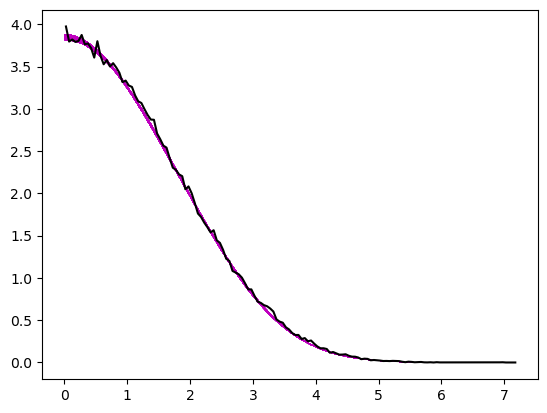

In [68]:
# now plot the new data 
for i in range(len(bcs)):    
    plt.scatter(zsparse,bcs[i],s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.show()

In [69]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
#print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.         -0.8802755   0.79561073]
 [-0.8802755   1.         -0.97845613]
 [ 0.79561073 -0.97845613  1.        ]]


Note that parameters are highly correlated, as you can see by the correlation matrix  - there are multiple parameters that give essentially the same result. It may be a 2 parameter fit is enough!  Bootstrapping over osmotic coefficients should give less noisy results.

Parma 0 = 2.543996160738071 +/- 0.4431062008353603


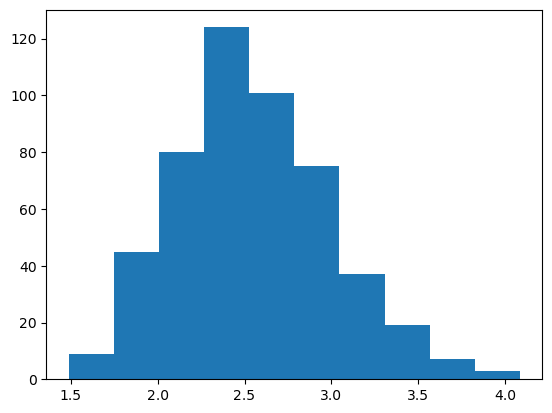

Parma 1 = 0.22390287883565696 +/- 0.026495950887986036


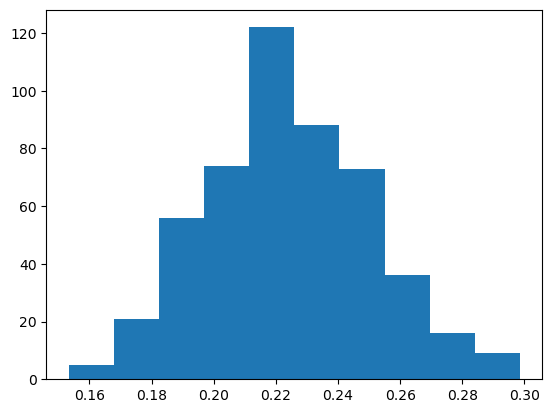

Parma 2 = -0.020691283718355814 +/- 0.0042511499720079785


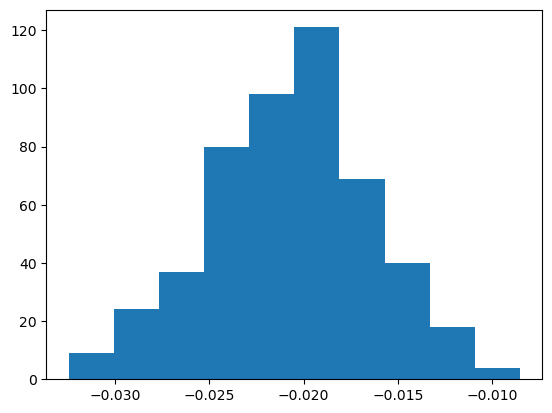

In [70]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Note that the standard deviations of the parameters are lower with the maximum likelihood approximation.

B: 
weighted: 1.33 +/- 0.65
ML: 2.54 +/- 0.44

$\alpha_1$: 
weighted: 0.357 +/- 0.127
ML: 0.223 +/- 0.025

$\alpha_2$: 
weighted: -0.0317 +/- 0.0102
ML:  -0.0205 +/- 0.0041

Note that it is OK that the uncertainties are not within each other, since this is a highly correlated problem, so there are multiple solutions - small change in optimization can lead to large changes in the parameters while still being relatively close. 

In [71]:
def osmotic_pressure(cs,params, nu=2):
    # takes in a concentration, model parameters and nu. 
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4)
    ip = nu*R*T*cs  # this should be the ideal osmotic pressure
    return p,p/ip

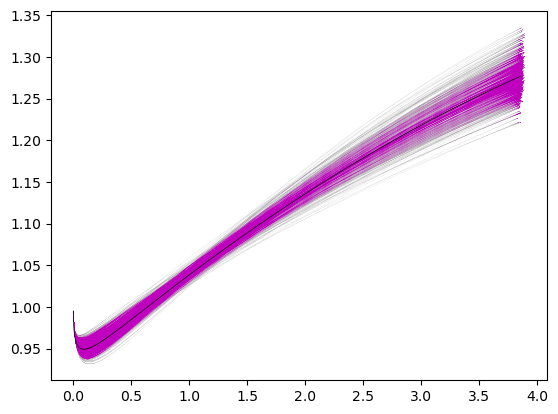

In [72]:
# scatter plots of the osmotic coefficients and osmotic pressures
ops = list()
ocs = list()
for p,c in zip(bparams,bcs):
    op,oc = osmotic_pressure(c,p)
    plt.scatter(c,oc,s=0.1,lw=0.1,alpha=0.01,c='m')
    ops.append(op)
    ocs.append(oc)
opt_oc = osmotic_pressure(c_opt_sparse,full_opt)[1]
plt.plot(c_opt_sparse,opt_oc,'k',lw=0.5,)
ops = np.array(ops)
ocs = np.array(ocs)
plt.show()

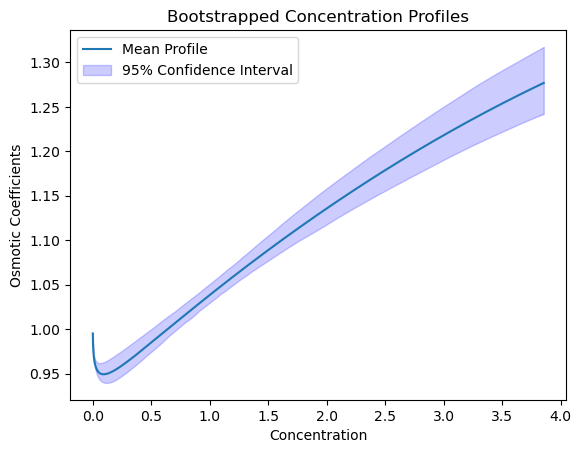

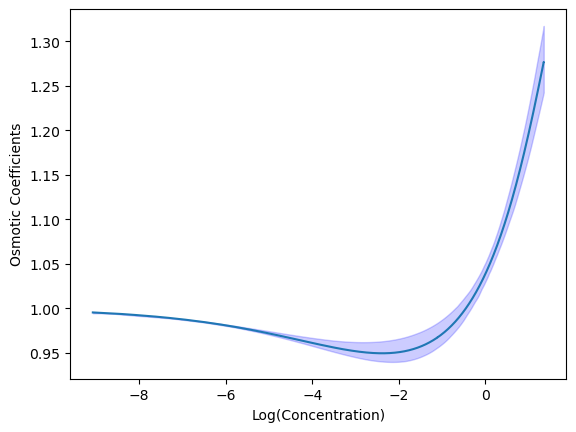

In [73]:
lower_bound = np.percentile(ocs, 2.5, axis=0)
upper_bound = np.percentile(ocs, 97.5, axis=0)
# Plotting the results
plt.plot(c_opt_sparse, opt_oc, label='Mean Profile')
plt.fill_between(c_opt_sparse, lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Concentration')
plt.ylabel('Osmotic Coefficients')
plt.legend()
plt.title('Bootstrapped Concentration Profiles')
plt.show()
plt.plot(np.log(c_opt_sparse), opt_oc, label='Mean Profile')
plt.fill_between(np.log(c_opt_sparse), lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.show()